In [ ]:
from pyspark.sql import SparkSession
from pyspark.sql.functions import col, split, udf, expr, sum, desc, lit
from pyspark.sql.types import IntegerType, FloatType, StringType
from pyspark.ml.recommendation import ALS
from pyspark.ml.evaluation import RegressionEvaluator
from pyspark import SparkConf, SparkContext
from pyspark.ml.feature import StringIndexer
import pyspark.sql.functions as F
import matplotlib.pyplot as plt
import socket
import platform
import pandas as pd
import numpy as np
from pyspark.sql import Row 
from pyspark.mllib.recommendation import ALS, Rating
import seaborn as sns 
from pyspark.ml.recommendation import ALSModel

In [5]:
#Separate training and test data
(training, test) = ratings_df.randomSplit([0.7, 0.3], seed=5084)

#Parameter combinations
ranks = [10, 50, 200]
iterations = [10, 50, 200]
lambdas = [0.01, 0.1]

#Evaluative objects
evaluator_rmse = RegressionEvaluator(metricName="rmse", labelCol="rating", predictionCol="prediction")
evaluator_mse = RegressionEvaluator(metricName="mse", labelCol="rating", predictionCol="prediction")

#List to collect results
results = []

#Variables to keep the best model
lowest_rmse = float("inf")
best_model_spec = None
best_params = {}

#Model training and evaluation cycle
for rank in ranks:
    for iteration in iterations:
        for reg in lambdas:
            als = ALS(
                maxIter=iteration,
                regParam=reg,
                rank=rank,
                userCol="user_id",
                itemCol="book_id",
                ratingCol="rating",
                coldStartStrategy="drop",
                seed=5084
            )
            model = als.fit(training)
            predictions = model.transform(test)

            rmse = evaluator_rmse.evaluate(predictions)
            mse = evaluator_mse.evaluate(predictions)

            print(f"Rank: {rank}, Iteration: {iteration}, Lambda: {reg} -> RMSE: {rmse:.4f}, MSE: {mse:.4f}")

            results.append({
                "rank": rank,
                "iteration": iteration,
                "lambda": reg,
                "RMSE": rmse,
                "MSE": mse
            })

            #Update the model with the lowest RMSE
            if rmse < lowest_rmse:
                lowest_rmse = rmse
                best_model_spec = model
                best_params = {"rank": rank, "iteration": iteration, "lambda": reg}

#Convert results to DataFrame
results_df = pd.DataFrame(results)
display(results_df)

#Print best parameters
print("\nBest model parameters:")
print(best_params)

#Save best model
best_model_spec.save("als_model_final")
print("Best ALS model saved to 'als_model_final'.")


Rank: 10, Iteration: 10, Lambda: 0.01 -> RMSE: 1.9982, MSE: 3.9930
Rank: 10, Iteration: 10, Lambda: 0.1 -> RMSE: 1.7700, MSE: 3.1329


Py4JJavaError: An error occurred while calling o332.fit.
: org.apache.spark.SparkException: Job 20 cancelled because SparkContext was shut down
	at org.apache.spark.scheduler.DAGScheduler$$anonfun$cleanUpAfterSchedulerStop$1.apply(DAGScheduler.scala:932)
	at org.apache.spark.scheduler.DAGScheduler$$anonfun$cleanUpAfterSchedulerStop$1.apply(DAGScheduler.scala:930)
	at scala.collection.mutable.HashSet.foreach(HashSet.scala:78)
	at org.apache.spark.scheduler.DAGScheduler.cleanUpAfterSchedulerStop(DAGScheduler.scala:930)
	at org.apache.spark.scheduler.DAGSchedulerEventProcessLoop.onStop(DAGScheduler.scala:2128)
	at org.apache.spark.util.EventLoop.stop(EventLoop.scala:84)
	at org.apache.spark.scheduler.DAGScheduler.stop(DAGScheduler.scala:2041)
	at org.apache.spark.SparkContext$$anonfun$stop$6.apply$mcV$sp(SparkContext.scala:1949)
	at org.apache.spark.util.Utils$.tryLogNonFatalError(Utils.scala:1340)
	at org.apache.spark.SparkContext.stop(SparkContext.scala:1948)
	at org.apache.spark.SparkContext$$anonfun$2.apply$mcV$sp(SparkContext.scala:575)
	at org.apache.spark.util.SparkShutdownHook.run(ShutdownHookManager.scala:216)
	at org.apache.spark.util.SparkShutdownHookManager$$anonfun$runAll$1$$anonfun$apply$mcV$sp$1.apply$mcV$sp(ShutdownHookManager.scala:188)
	at org.apache.spark.util.SparkShutdownHookManager$$anonfun$runAll$1$$anonfun$apply$mcV$sp$1.apply(ShutdownHookManager.scala:188)
	at org.apache.spark.util.SparkShutdownHookManager$$anonfun$runAll$1$$anonfun$apply$mcV$sp$1.apply(ShutdownHookManager.scala:188)
	at org.apache.spark.util.Utils$.logUncaughtExceptions(Utils.scala:1945)
	at org.apache.spark.util.SparkShutdownHookManager$$anonfun$runAll$1.apply$mcV$sp(ShutdownHookManager.scala:188)
	at org.apache.spark.util.SparkShutdownHookManager$$anonfun$runAll$1.apply(ShutdownHookManager.scala:188)
	at org.apache.spark.util.SparkShutdownHookManager$$anonfun$runAll$1.apply(ShutdownHookManager.scala:188)
	at scala.util.Try$.apply(Try.scala:192)
	at org.apache.spark.util.SparkShutdownHookManager.runAll(ShutdownHookManager.scala:188)
	at org.apache.spark.util.SparkShutdownHookManager$$anon$2.run(ShutdownHookManager.scala:178)
	at org.apache.hadoop.util.ShutdownHookManager$1.run(ShutdownHookManager.java:54)
	at org.apache.spark.scheduler.DAGScheduler.runJob(DAGScheduler.scala:737)
	at org.apache.spark.SparkContext.runJob(SparkContext.scala:2061)
	at org.apache.spark.SparkContext.runJob(SparkContext.scala:2082)
	at org.apache.spark.SparkContext.runJob(SparkContext.scala:2101)
	at org.apache.spark.SparkContext.runJob(SparkContext.scala:2126)
	at org.apache.spark.rdd.RDD.count(RDD.scala:1168)
	at org.apache.spark.ml.recommendation.ALS$.train(ALS.scala:1031)
	at org.apache.spark.ml.recommendation.ALS$$anonfun$fit$1.apply(ALS.scala:676)
	at org.apache.spark.ml.recommendation.ALS$$anonfun$fit$1.apply(ALS.scala:658)
	at org.apache.spark.ml.util.Instrumentation$$anonfun$11.apply(Instrumentation.scala:183)
	at scala.util.Try$.apply(Try.scala:192)
	at org.apache.spark.ml.util.Instrumentation$.instrumented(Instrumentation.scala:183)
	at org.apache.spark.ml.recommendation.ALS.fit(ALS.scala:658)
	at sun.reflect.NativeMethodAccessorImpl.invoke0(Native Method)
	at sun.reflect.NativeMethodAccessorImpl.invoke(NativeMethodAccessorImpl.java:62)
	at sun.reflect.DelegatingMethodAccessorImpl.invoke(DelegatingMethodAccessorImpl.java:43)
	at java.lang.reflect.Method.invoke(Method.java:498)
	at py4j.reflection.MethodInvoker.invoke(MethodInvoker.java:244)
	at py4j.reflection.ReflectionEngine.invoke(ReflectionEngine.java:357)
	at py4j.Gateway.invoke(Gateway.java:282)
	at py4j.commands.AbstractCommand.invokeMethod(AbstractCommand.java:132)
	at py4j.commands.CallCommand.execute(CallCommand.java:79)
	at py4j.GatewayConnection.run(GatewayConnection.java:238)
	at java.lang.Thread.run(Thread.java:748)


In [2]:
ratings_df.printSchema()

root
 |-- user_id: integer (nullable = true)
 |-- book_id: integer (nullable = true)
 |-- rating: integer (nullable = true)



In [5]:
ratings_df.count()

10000000

In [1]:
# Change configurations sets
conf = SparkConf()
conf.set("spark.driver.memory", "18g")           
conf.set("spark.driver.maxResultSize", "6g")     
conf.set("spark.executor.memory", "4g")          

spark = SparkSession.builder \
    .appName("ALS_HighMemory") \
    .master("local[*]") \
    .config(conf=conf) \
    .getOrCreate()

sc = spark.sparkContext
# CSV read
goodreads_interactions_df = spark.read.csv("goodreads_interactions.csv", header=True, inferSchema=True)
# Select columns
ratings_df = goodreads_interactions_df.select("user_id", "book_id", "rating")
ratings_df.select([sum(col(c).isNull().cast("int")).alias(c) for c in ratings_df.columns]).show()
# Adjust the number of partitions to balance shuffle and memory pressure
spark.conf.set("spark.sql.shuffle.partitions", "200")
ratings_df = ratings_df.repartition(200, "user_id")
(training, test) = ratings_df.randomSplit([0.7, 0.3], seed=5084)
# Cache + materialize
training.cache()
training.count()
# Checkpoint index (to shorten lineage)
sc.setCheckpointDir("spark-checkpoints/")
# evaluators
evaluator_rmse = RegressionEvaluator(metricName="rmse", labelCol="rating", predictionCol="prediction")
evaluator_mse = RegressionEvaluator(metricName="mse", labelCol="rating", predictionCol="prediction")

+-------+-------+------+
|user_id|book_id|rating|
+-------+-------+------+
|      0|      0|     0|
+-------+-------+------+



In [ ]:
#Parameter combinations
ranks = [10, 50, 200]
iterations = [10, 50, 200]
lambdas = [0.01, 0.1]

#List to collect results
results = []

#Variables to keep the best model
lowest_rmse = float("inf")
best_model_spec = None
best_params = {}

#Model training and evaluation cycle
for rank in ranks:
    for iteration in iterations:
        for reg in lambdas:
            als = ALS(
                maxIter=iteration,
                regParam=reg,
                rank=rank,
                userCol="user_id",
                itemCol="book_id",
                ratingCol="rating",
                coldStartStrategy="drop",
                seed=5084
            ).setCheckpointInterval(5) # clear lineage every 5 iterations
            model = als.fit(training)
            predictions = model.transform(test)

            rmse = evaluator_rmse.evaluate(predictions)
            mse = evaluator_mse.evaluate(predictions)

            print(f"Rank: {rank}, Iteration: {iteration}, Lambda: {reg} -> RMSE: {rmse:.4f}, MSE: {mse:.4f}")

            results.append({
                "rank": rank,
                "iteration": iteration,
                "lambda": reg,
                "RMSE": rmse,
                "MSE": mse
            })

            #Update the model with the lowest RMSE
            if rmse < lowest_rmse:
                lowest_rmse = rmse
                best_model_spec = model
                best_params = {"rank": rank, "iteration": iteration, "lambda": reg}

#Convert results to DataFrame
results_df = pd.DataFrame(results)
display(results_df)

#Print best parameters
print("\nBest model parameters:")
print(best_params)

#Save best model
best_model_spec.save("als_model_final")
print("Best ALS model saved to 'als_model_final'.")

Rank: 10, Iteration: 10, Lambda: 0.01 -> RMSE: 1.9990, MSE: 3.9961
Rank: 10, Iteration: 10, Lambda: 0.1 -> RMSE: 1.7705, MSE: 3.1347
Rank: 10, Iteration: 50, Lambda: 0.01 -> RMSE: 2.0672, MSE: 4.2735
Rank: 10, Iteration: 50, Lambda: 0.1 -> RMSE: 1.7617, MSE: 3.1036
Rank: 10, Iteration: 200, Lambda: 0.01 -> RMSE: 2.0771, MSE: 4.3141
Rank: 10, Iteration: 200, Lambda: 0.1 -> RMSE: 1.7587, MSE: 3.0929
Rank: 50, Iteration: 10, Lambda: 0.01 -> RMSE: 2.0999, MSE: 4.4094
Rank: 50, Iteration: 10, Lambda: 0.1 -> RMSE: 1.7216, MSE: 2.9638
Rank: 50, Iteration: 50, Lambda: 0.01 -> RMSE: 2.1422, MSE: 4.5890
Rank: 50, Iteration: 50, Lambda: 0.1 -> RMSE: 1.7188, MSE: 2.9544
Rank: 50, Iteration: 200, Lambda: 0.01 -> RMSE: 2.1436, MSE: 4.5951
Rank: 50, Iteration: 200, Lambda: 0.1 -> RMSE: 1.7187, MSE: 2.9538
Rank: 200, Iteration: 10, Lambda: 0.01 -> RMSE: 1.9178, MSE: 3.6779
Rank: 200, Iteration: 10, Lambda: 0.1 -> RMSE: 1.6928, MSE: 2.8655
Rank: 200, Iteration: 50, Lambda: 0.01 -> RMSE: 1.8604, MSE: 3.

In [1]:
#Executor memory increased to 8g.
conf = SparkConf()
conf.set("spark.driver.memory", "18g")            
conf.set("spark.driver.maxResultSize", "6g")     
conf.set("spark.executor.memory", "8g")          
spark = SparkSession.builder \
    .appName("ALS_HighMemory") \
    .master("local[*]") \
    .config(conf=conf) \
    .getOrCreate()

sc = spark.sparkContext
# CSV read
goodreads_interactions_df = spark.read.csv("goodreads_interactions.csv", header=True, inferSchema=True)

# Select columns
ratings_df = goodreads_interactions_df.select("user_id", "book_id", "rating")
ratings_df.select([sum(col(c).isNull().cast("int")).alias(c) for c in ratings_df.columns]).show()

# Adjust the number of partitions to balance shuffle and memory pressure
spark.conf.set("spark.sql.shuffle.partitions", "100")
ratings_df = ratings_df.repartition(100, "user_id")
(training, test) = ratings_df.randomSplit([0.7, 0.3], seed=5084)

# Cache + materialize
training.cache()
training.count()
sc.setCheckpointDir("spark-checkpoints/")

evaluator_rmse = RegressionEvaluator(metricName="rmse", labelCol="rating", predictionCol="prediction")
evaluator_mse = RegressionEvaluator(metricName="mse", labelCol="rating", predictionCol="prediction")

+-------+-------+------+
|user_id|book_id|rating|
+-------+-------+------+
|      0|      0|     0|
+-------+-------+------+



In [2]:
rank=200
iteration=50
reg=0.1

als_001 = ALS(
    maxIter=iteration,
    regParam=reg,
    rank=rank,
    userCol="user_id",
    itemCol="book_id",
    ratingCol="rating",
    coldStartStrategy="drop",
    seed=5084
).setCheckpointInterval(5)
model = als_001.fit(training)
predictions = model.transform(test)

rmse = evaluator_rmse.evaluate(predictions)
mse = evaluator_mse.evaluate(predictions)

print(f"Rank: {rank}, Iteration: {iteration}, Lambda: {reg} -> RMSE: {rmse:.4f}, MSE: {mse:.4f}")

model.save("als_model_rank200_iter50_lambda0.1")


Rank: 200, Iteration: 50, Lambda: 0.1 -> RMSE: 1.6917, MSE: 2.8617


In [2]:
rank=200
iteration=200
reg=0.1

als_01 = ALS(
    maxIter=iteration,
    regParam=reg,
    rank=rank,
    userCol="user_id",
    itemCol="book_id",
    ratingCol="rating",
    coldStartStrategy="drop",
    seed=5084
).setCheckpointInterval(10)
model = als_01.fit(training)
predictions = model.transform(test)

rmse = evaluator_rmse.evaluate(predictions)
mse = evaluator_mse.evaluate(predictions)

print(f"Rank: {rank}, Iteration: {iteration}, Lambda: {reg} -> RMSE: {rmse:.4f}, MSE: {mse:.4f}")

model.save("als_model_rank200_iter200_lambda0.1")

Rank: 200, Iteration: 200, Lambda: 0.1 -> RMSE: 1.6917, MSE: 2.8618


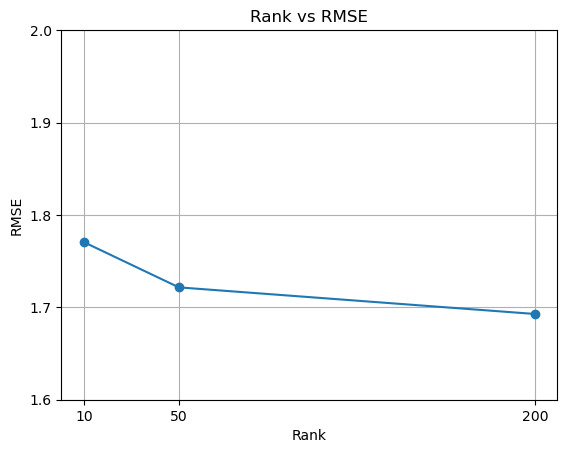

In [11]:
# rank and RMSE values, Iteration=10,lambda=0.1
x_values = [10, 50, 200]               # rank
y_values = [1.7705, 1.7216, 1.6928]    # RMSE 

plt.plot(x_values, y_values, marker='o')
plt.title("Rank vs RMSE")
plt.xlabel("Rank")
plt.ylabel("RMSE")
plt.xticks(x_values)
plt.yticks([1.6, 1.7, 1.8, 1.9, 2.0])  
plt.grid(True)
plt.show()

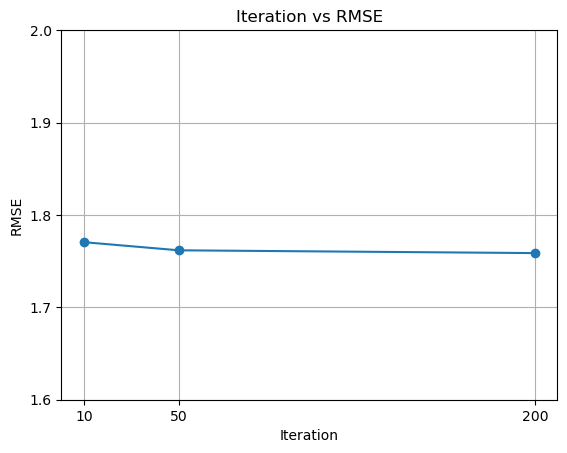

In [13]:
# Iteration and RMSE values, Rank=10,lambda=0.1
x_values = [10, 50, 200]               # Iteration
y_values = [1.7705, 1.7617, 1.7587]    # RMSE 

plt.plot(x_values, y_values, marker='o')
plt.title("Iteration vs RMSE")
plt.xlabel("Iteration")
plt.ylabel("RMSE")
plt.xticks(x_values)
plt.yticks([1.6, 1.7, 1.8, 1.9, 2.0])  
plt.grid(True)
plt.show()

In [64]:
interactions_df.printSchema()

root
 |-- user_id: integer (nullable = true)
 |-- book_id: integer (nullable = true)
 |-- is_read: integer (nullable = true)
 |-- rating: integer (nullable = true)
 |-- is_reviewed: integer (nullable = true)



In [74]:
print(book_map_df.columns)   
print(books_df.columns)    

['book_id_csv', 'book_id']
['asin', 'authors', 'average_rating', 'book_id', 'country_code', 'description', 'edition_information', 'format', 'image_url', 'is_ebook', 'isbn', 'isbn13', 'kindle_asin', 'language_code', 'link', 'num_pages', 'popular_shelves', 'publication_day', 'publication_month', 'publication_year', 'publisher', 'ratings_count', 'series', 'similar_books', 'text_reviews_count', 'title', 'title_without_series', 'url', 'work_id']


In [ ]:
titles = book_titles_df.select("book_id_csv", "title") \
    .rdd.map(lambda row: (row.book_id_csv, row.title)) \
    .collectAsMap()

In [6]:
conf = SparkConf()
conf.set("spark.driver.memory", "18g")           
conf.set("spark.driver.maxResultSize", "6g")   
conf.set("spark.executor.memory", "8g")        
spark = SparkSession.builder \
    .appName("ALS_Books") \
    .master("local[*]") \
    .config(conf=conf) \
    .getOrCreate()

# read JSON file
books_df = spark.read.json("goodreads_books.json") 
books_df.printSchema()
print(books_df.columns)
books_df.show(5)

root
 |-- asin: string (nullable = true)
 |-- authors: array (nullable = true)
 |    |-- element: struct (containsNull = true)
 |    |    |-- author_id: string (nullable = true)
 |    |    |-- role: string (nullable = true)
 |-- average_rating: string (nullable = true)
 |-- book_id: string (nullable = true)
 |-- country_code: string (nullable = true)
 |-- description: string (nullable = true)
 |-- edition_information: string (nullable = true)
 |-- format: string (nullable = true)
 |-- image_url: string (nullable = true)
 |-- is_ebook: string (nullable = true)
 |-- isbn: string (nullable = true)
 |-- isbn13: string (nullable = true)
 |-- kindle_asin: string (nullable = true)
 |-- language_code: string (nullable = true)
 |-- link: string (nullable = true)
 |-- num_pages: string (nullable = true)
 |-- popular_shelves: array (nullable = true)
 |    |-- element: struct (containsNull = true)
 |    |    |-- count: string (nullable = true)
 |    |    |-- name: string (nullable = true)
 |-- pub

In [7]:
books_small_df = books_df.select(
    col("book_id").cast(IntegerType()).alias("book_id"),
    col("title")
)

#control
books_small_df.printSchema()
books_small_df.show(5, truncate=False)

root
 |-- book_id: integer (nullable = true)
 |-- title: string (nullable = true)

+-------+--------------------------------------------------------------------+
|book_id|title                                                               |
+-------+--------------------------------------------------------------------+
|5333265|W.C. Fields: A Life on Film                                         |
|1333909|Good Harbor                                                         |
|7327624|The Unschooled Wizard (Sun Wolf and Starhawk, #1-2)                 |
|6066819|Best Friends Forever                                                |
|287140 |Runic Astrology: Starcraft and Timekeeping in the Northern Tradition|
+-------+--------------------------------------------------------------------+
only showing top 5 rows



In [8]:
null_counts = books_small_df.select([
    sum(col(c).isNull().cast("int")).alias(c) 
    for c in books_small_df.columns
])
null_counts.show()

+-------+-----+
|book_id|title|
+-------+-----+
|      0|    0|
+-------+-----+



In [10]:
target_book_id = 123
item_row = item_factors.filter(col("id") == target_book_id).first()
if item_row is None:
    raise ValueError(f"item_factors içinde book_id={target_book_id} bulunamadı.")
target_features = item_row.features
# Cosine similarity with itself (always 1.0) we compare target_features with target_features:
self_similarity = float(np.dot(target_features, target_features) /
                        (np.linalg.norm(target_features) * np.linalg.norm(target_features)))
print(f"Hedef ürünün kendisiyle cosine similarity’si: {self_similarity:.4f}")

Hedef ürünün kendisiyle cosine similarity’si: 1.0000


In [9]:
spark = SparkSession.builder \
    .appName("ALS_Top10_Users_With_BookTitle_And_ID") \
    .master("local[*]") \
    .getOrCreate()

books_df = spark.read.json("goodreads_books.json") \
    .select(
        col("book_id").cast(IntegerType()).alias("book_id"),
        col("title")
    )

goodreads_interactions_df = spark.read.csv(
    "goodreads_interactions.csv", header=True, inferSchema=True
)
ratings_df = goodreads_interactions_df.select("user_id", "book_id", "rating")

#  Load the ALS model you saved earlier
model_path = "als_model_rank200_iter50_lambda0.1"
model = ALSModel.load(model_path)

#Get latent factors from model
user_factors = model.userFactors   # ["id" = user_id,        "features" = Array[Float] ]
item_factors = model.itemFactors   # ["id" = book_id,        "features" = Array[Float] ]

# Determine target book ID and get latent vector
item_row = item_factors.filter(col("id") == target_book_id).first()
if item_row is None:
    raise ValueError(f"item_factors içinde book_id={target_book_id} bulunamadı.")
target_features = item_row.features
# Get target book title from JSON
product_title_row = books_df.filter(col("book_id") == target_book_id).first()
product_title = product_title_row["title"] if product_title_row else "(Başlık bulunamadı)"

# Cosine similarity UDF
def cosine_similarity(vec, target_vec):
    dot = float(np.dot(vec, target_vec))
    norm1 = float(np.linalg.norm(vec))
    norm2 = float(np.linalg.norm(target_vec))
    if norm1 == 0.0 or norm2 == 0.0:
        return 0.0
    return dot / (norm1 * norm2)

cos_sim_udf = udf(lambda user_feats: cosine_similarity(user_feats, target_features), FloatType())

#Calculate cosine similarity score for each user
user_similarities = user_factors.withColumn("similarity", cos_sim_udf(col("features")))

#Take the top 10 users with the highest cosine similarity, and add “book_id” and “product_title” to each row
top_10_cosine = (
    user_similarities.orderBy(desc("similarity"))
                   .limit(10)
                   .withColumn("book_id", lit(target_book_id))
                   .withColumn("product_title", lit(product_title))
)

print("=== Cosine Similarity’ye Göre En Çok Beğenecek 10 Kullanıcı (book_id ve product_title dahil) ===")
top_10_cosine.select(
    col("id").alias("user_id"),
    col("book_id"),
    col("product_title"),
    col("similarity")
).show(truncate=False)

# Find the 10 most liked users according to ALS Prediction
all_users = ratings_df.select("user_id").distinct()
product_df = spark.createDataFrame([(target_book_id,)], ["book_id"])
user_product_df = all_users.crossJoin(product_df)

predictions_for_product = model.transform(user_product_df)

top_10_prediction = (
    predictions_for_product.orderBy(desc("prediction"))
                           .limit(10)
                           .withColumn("product_title", lit(product_title))
)

print("=== ALS Tahmin Skoruna Göre En Çok Beğenecek 10 Kullanıcı (book_id ve product_title dahil) ===")
top_10_prediction.select(
    "user_id",
    "book_id",
    "product_title",
    "prediction"
).show(truncate=False)

=== Cosine Similarity’ye Göre En Çok Beğenecek 10 Kullanıcı (book_id ve product_title dahil) ===
+-------+-------+---------------------------------------+----------+
|user_id|book_id|product_title                          |similarity|
+-------+-------+---------------------------------------+----------+
|11297  |123    |The Power of One (The Power of One, #1)|0.47962752|
|12502  |123    |The Power of One (The Power of One, #1)|0.46698317|
|16930  |123    |The Power of One (The Power of One, #1)|0.4634295 |
|10818  |123    |The Power of One (The Power of One, #1)|0.46161336|
|7645   |123    |The Power of One (The Power of One, #1)|0.4598129 |
|6527   |123    |The Power of One (The Power of One, #1)|0.4477329 |
|18540  |123    |The Power of One (The Power of One, #1)|0.44239244|
|19005  |123    |The Power of One (The Power of One, #1)|0.44025186|
|2637   |123    |The Power of One (The Power of One, #1)|0.43611065|
|7892   |123    |The Power of One (The Power of One, #1)|0.43354878|
+-----

In [14]:
spark = SparkSession.builder \
    .appName("LoadALSModelAndPredict_With_BookTitle") \
    .master("local[*]") \
    .getOrCreate()

books_df = spark.read.json("goodreads_books.json") \
    .select(
        col("book_id").cast("int").alias("book_id"),
        col("title")
    )

model_path = "als_model_rank200_iter50_lambda0.1"
loaded_model = ALSModel.load(model_path)

goodreads_interactions_df = spark.read.csv(
    "goodreads_interactions.csv", header=True, inferSchema=True
)
ratings_df = goodreads_interactions_df.select("user_id", "book_id", "rating")

# Separate training and test data
(training, test) = ratings_df.randomSplit([0.7, 0.3], seed=5084)


# Make predictions on test set with loaded model DataFrame “test” should have columns “user_id” and “book_id”

predictions = loaded_model.transform(test)

# Join DataFrame “predictions” with “books_df” based on book_id
pred_with_title = predictions.join(
    books_df,
    on="book_id",
    how="left"
)
pred_with_title.select(
    "user_id",
    "book_id",
    "title",
    "rating",
    "prediction"
).show(10, truncate=False)

+-------+-------+-----+------+----------+
|user_id|book_id|title|rating|prediction|
+-------+-------+-----+------+----------+
|2924   |148    |null |3     |2.9316087 |
|3561   |148    |null |4     |1.9008758 |
|16565  |148    |null |0     |1.0484502 |
|14437  |148    |null |0     |0.64298236|
|19480  |148    |null |4     |3.8118997 |
|530    |148    |null |5     |3.8120437 |
|4153   |148    |null |5     |4.123562  |
|874    |148    |null |4     |2.375707  |
|4443   |148    |null |0     |0.668987  |
|4482   |148    |null |0     |0.1262442 |
+-------+-------+-----+------+----------+
only showing top 10 rows



In [16]:
#check if book number "1123" is present in JSON
books_df.filter(col("book_id") == 1123).show()

+-------+--------------------+
|book_id|               title|
+-------+--------------------+
|   1123|Eating for Life: ...|
+-------+--------------------+



In [3]:
spark = SparkSession.builder \
    .appName("PredictWithTrueRatingAndBookTitle") \
    .master("local[*]") \
    .getOrCreate()
books_df = spark.read.json("goodreads_books.json") \
    .select(
        col("book_id").cast("int").alias("book_id"),
        col("title")
    )
model_path = "als_model_rank200_iter50_lambda0.1"
loaded_model = ALSModel.load(model_path)

goodreads_interactions_df = spark.read.csv(
    "goodreads_interactions.csv", header=True, inferSchema=True
)
ratings_df = goodreads_interactions_df.select("user_id", "book_id", "rating")

training, test = ratings_df.randomSplit([0.7, 0.3], seed=5084)

target_book_id = 1123 

distinct_with_rating = (
    test
    .filter(col("book_id") == target_book_id)  
    .select("user_id", "book_id", "rating")
    .limit(10)
)

# Create DataFrame containing only user_id + book_id to make ALS predict
user_book_df = distinct_with_rating.select("user_id", "book_id")

predictions_for_10 = loaded_model.transform(user_book_df)

# Return the real rating column by joining predictions_for_10 with distinct_with_rating via user_id+book_id
pred_with_true_rating = predictions_for_10.join(
    distinct_with_rating,
    on=["user_id", "book_id"],
    how="left"
)
# After this step columns = [user_id, book_id, prediction, rating]
# Add title column by joining books_df on book_id
pred_with_title = pred_with_true_rating.join(
    books_df,
    on="book_id",
    how="left"
)
# Now columns = [book_id, user_id, prediction, rating, title]
pred_with_title.select(
    "user_id",
    "book_id",
    "title",
    "rating",
    "prediction"
).show(truncate=False)

+-------+-------+---------------------------------------------------------------------------+------+----------+
|user_id|book_id|title                                                                      |rating|prediction|
+-------+-------+---------------------------------------------------------------------------+------+----------+
|65     |1123   |Eating for Life: Your Guide to Great Health, Fat Loss and Increased Energy!|3     |3.3958015 |
|91     |1123   |Eating for Life: Your Guide to Great Health, Fat Loss and Increased Energy!|3     |3.5327349 |
|22     |1123   |Eating for Life: Your Guide to Great Health, Fat Loss and Increased Energy!|3     |2.0910542 |
|61     |1123   |Eating for Life: Your Guide to Great Health, Fat Loss and Increased Energy!|3     |2.5755076 |
|4      |1123   |Eating for Life: Your Guide to Great Health, Fat Loss and Increased Energy!|2     |2.2986987 |
|39     |1123   |Eating for Life: Your Guide to Great Health, Fat Loss and Increased Energy!|4     |3.73